In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import entropy
from matplotlib import cm
%matplotlib notebook

In [2]:
def ismember(A,B):
    import numpy as np
    return [ np.sum(a == B) for a in A ]

def get_K(d): 
    import numpy as np
    import numpy.matlib
    Sniter = np.array(range(d))
    Sniter = np.matlib.repmat(Sniter,d,1)
    Sniter = Sniter.reshape((1,d**2))
    Smiter = np.array(range(d))
    Smiter = np.matlib.repmat(Smiter,d,1)
    Smiter = Smiter.T.reshape((1,d**2))

    # starting with all operators except (0,0)
    Sniter_all = Sniter[0][1:]
    Smiter_all = Smiter[0][1:]

    Sniter = [1] + [ii for ii in range(d)]
    Smiter = [0] + [1 for ii in range(d)]

    op_All = [(Smiter_all[ii], Sniter_all[ii]) for ii in range(len(Sniter_all))]
    op_Current = [(Sniter[ii], Smiter[ii]) for ii in range(d)]
    
    n_eigVals = [d/np.gcd(W[0], np.gcd(W[1], d)) for W in op_All]
    #for ii, ee in zip(op_All, n_eigVals):
    #    print(ii, ee)
        
    op_tempKept = [op_All[ii] for ii in range(len(op_All)) if n_eigVals[ii] == d] # all full-rank operators
    
    op_finalKept = [op_tempKept[0]]
    for W in op_tempKept:
        L = [(K[0]*W[1] - K[1]*W[0])%d for K in op_finalKept]
        if 0 not in L:
            op_finalKept.append(W)
        #print(op_finalKept)
    
    #print(len(op_finalKept))
    Sniter = [W[0] for W in op_finalKept]
    Smiter = [W[1] for W in op_finalKept]
    #print(Sniter)



    eigRel = np.zeros((len(Sniter),d**2))
    for kk in range(len(Sniter)):
        appOp = 0;
        for nn in range(d):
            for mm in range(d):
                eigRel[kk,appOp] = (Smiter[kk]*nn - Sniter[kk]*mm)%d#(mm*g - nn*t)%d
                appOp +=1
    eig_Rel = {(Sniter[ii], Smiter[ii]): list(eigRel[ii]) for ii in range(len(Sniter))}


    idx_opers = list(eig_Rel.keys()) # indices of Weyl operators generators of input states
    out_rels = list(eig_Rel.values()) # corresponding output relations
    rel_matrix = np.matrix([np.array(row)==kk for row in out_rels for kk in range(d)], dtype = int) 
    return(idx_opers, rel_matrix)

In [3]:
def eig_e_corr(d,rho):
    """Returns normalized eigenvalues of d^2 x d^2 dimensional exponential correlation matrix with correlation coefficient rho"""
    ec_Mat = np.zeros((d**2,d**2))
    for x in range(0,d**2):
        for y in range(0,d**2):
            ec_Mat[x,y] = rho**(abs(x - y))
    eig_e = np.linalg.eig(ec_Mat)
    eig_e = eig_e[0]/np.sum(eig_e[0])
    return(eig_e)

def DWC_tom_fast(AA):
    import numpy as np
    exp_obs,N, rel_matrix, rel_inv, pp,d = AA[0], AA[1], AA[2], AA[3], AA[4], AA[5]
    N_tom = round(N/(len(rel_matrix)/d))
    e_freq = [] # expected
    o_freq = [] # observed
    for kk in exp_obs:
        ideal = np.array(kk)
        ideal = ideal.clip(min = 0)
        freq = np.random.multinomial(N_tom, (1 - pp)*ideal + pp*np.ones(ideal.size)/d)/N_tom
        e_freq.extend(list(ideal))
        o_freq.extend(list(freq))
    o_freq = np.matrix(o_freq).T
    e_freq = np.matrix(e_freq).T
    x_ideal, resid, rank, s = np.linalg.lstsq(rel_matrix, e_freq, rcond = None)
    x_obs = rel_inv*o_freq#, resid, rank, s = np.linalg.lstsq(rel_matrix, o_freq, rcond = None)
    return (x_obs - x_ideal)

def empVar(AA):
    import numpy as np
    x_obs, M, N_vals, kkk = AA[0], AA[1], AA[2], AA[3]
    emp_var = np.var([[x_obs[ii+kk*M][kkk].tolist()[0][0] for ii in range(M)] for kk in range(len(N_vals))], axis = 1)
    return emp_var

def mmse(AA):
    import numpy as np
    x_obs, M, N_vals, kkk, aaa = AA[0], AA[1], AA[2], AA[3], AA[4]
    mse_val = np.mean([[(x_obs[ii+kk*M][kkk].tolist()[0][0] - aaa[kkk])**2 for ii in range(M)] for kk in range(len(N_vals))], axis = 1)
    return mse_val

def d_norm_anal(AA):
    import numpy as np
    Pxy, x_obs, d= AA[0], AA[1], AA[2]
    chan2 = np.array(np.reshape(x_obs/np.sum(x_obs), [d, d]))
    chan2 = chan2.clip(min = 0)
    chan2 = chan2/np.sum(chan2)
    d_norm = np.sum(np.abs(Pxy - chan2))
    return d_norm

def sq_sum(AA):
    import numpy as np
    y = np.sum([x**2 for x in AA])
    return y

In [4]:
# %% DWC tomography of a DWC
d = 2
M = 100# repeat for each N
noise_lev = np.linspace(0,1, 20)
gamm = np.linspace(0,0.99,21)
N_val = 10**5

Pxy = [eig_e_corr(d,g).real for g in gamm]
[pxy.sort() for pxy in Pxy]
aaa = Pxy
Pxy = [pxy.reshape((d,d)) for pxy in Pxy]

###
idx_opers, rel_matrix = get_K(d)
exp_obs = [np.reshape(rel_matrix*np.matrix(aaa[ii]).T,[int(len(rel_matrix)/d),int(d)]).tolist() 
           for ii in range(len(aaa))]
rel_inv = np.linalg.pinv(rel_matrix)
######################


var_Pxy = [np.sum(aaa[ii]*(1-aaa[ii])) for ii in range(len(aaa))]
#N_vals = [round(10**ii) for ii in N_vals]
print(M*len(noise_lev)*len(gamm), 'total tasks')

x_obs = list(map(DWC_tom_fast,[[exp_obs[ii],N_val, rel_matrix, rel_inv, noise_lev[jj], d] 
                                     for ii in range(len(exp_obs)) for jj in range(len(noise_lev)) for kk in range(M)])) # Should be divided by d+1




d_norm_v = [np.sum(np.abs(obs)) for obs in x_obs]
d_norm_p = np.mean(np.reshape(d_norm_v, [len(gamm), len(noise_lev), M]), axis = 2)


mse_v = list(map(sq_sum, x_obs))
#mse_v = [np.sum([x**2 for x in obs]) for obs in x_obs]
mse_p = np.mean(np.reshape(mse_v, [len(gamm), len(noise_lev), M]), axis = 2)



42000 total tasks


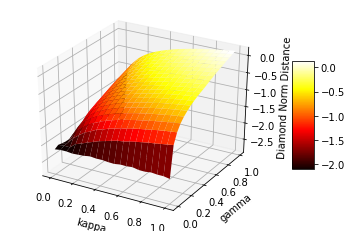

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(noise_lev, gamm)
zs = np.array(np.log10(d_norm_p))
Z = zs.reshape(X.shape)

surf = ax.plot_surface(X, Y, Z, cmap=cm.hot)

ax.set_xlabel('kappa')
ax.set_ylabel('gamma')
ax.set_zlabel('Diamond Norm Distance')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

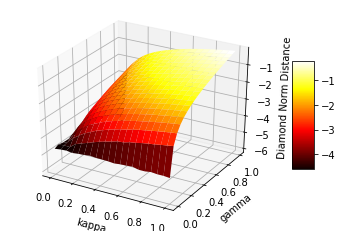

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(noise_lev, gamm)
zs = np.array(np.log10(mse_p))
Z = zs.reshape(X.shape)

surf = ax.plot_surface(X, Y, Z, cmap=cm.hot)

ax.set_xlabel('kappa')
ax.set_ylabel('gamma')
ax.set_zlabel('Diamond Norm Distance')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()